# Machine Translation + Transformer

<img src = "./figures/transformer1.png" >

In [136]:
import torch, torchdata, torchtext,datasets, math
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from nltk.translate.bleu_score import sentence_bleu

cpu


In [2]:
import spacy
spacy.__version__

'3.8.4'

In [3]:
# torch.cuda.get_device_name(0)

In [4]:
torch.__version__

'2.2.2+cu121'

In [5]:
torchtext.__version__

'0.17.2+cpu'

## 1. ETL: Loading the dataset

**Note**: The dataset is from TUFS Asian Language Parallel Corpus (TALPCo)

The TUFS Asian Language Parallel Corpus (TALPCo) is an open parallel corpus consisting of Japanese sentences and their translations into Korean, Burmese (Myanmar; the official language of the Republic of the Union of Myanmar), Malay (the national language of Malaysia, Singapore and Brunei), Indonesian, Thai, Vietnamese and English. TALPCo is licensed under a Creative Commons Attribution 4.0 International (CC BY 4.0) license. See the paper below for the details of TALPCo.


### Prepare data to upload to hugging face

In [92]:
from sklearn.model_selection import train_test_split
import re
import pandas as pd
with open('./app/data/data_eng.txt') as file:
    textEng = file.readlines()
with open('./app/data/data_myn.txt') as file:
    textMyn = file.readlines()
paired_lines = list(zip(textEng, textMyn))
print(paired_lines[0])

def preprocess(text):
    # Remove special characters with regular expression
    processed_text = re.sub('[^A-Za-z0-9က-၏ဠ-ဿ၀-၉၊။ ]+', '', text)
    processed_text = re.sub('\d+', '', processed_text)
    return processed_text.strip()

processed_corpus = {(preprocess(myanmar), preprocess(english)) for myanmar, english in paired_lines}
list(processed_corpus)[0]

# Build dataframe for train,val,test split
df = pd.DataFrame(processed_corpus, columns=['en', 'my'])

# Split twice for 80% train, 10% validation, 10% test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED)
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=SEED)

# Save files for upload
train_df.to_csv('./app/data/train.csv', index=False)
test_df.to_csv('./app/data/test.csv', index=False)
val_df.to_csv('./app/data/validation.csv', index=False)

('1176\tMr Tanaka is not a student.\n', '1176\tမစ္စတာတာနာခါဟာ ကျောင်းသား မဟုတ်ပါဘူး။\n')


In [7]:
dataset = datasets.load_dataset('kaung-nyo-lwin/english-myanmar')

## 2. EDA - simple investigation

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['en', 'my'],
        num_rows: 1093
    })
    validation: Dataset({
        features: ['en', 'my'],
        num_rows: 137
    })
    test: Dataset({
        features: ['en', 'my'],
        num_rows: 137
    })
})

In [9]:
SRC_LANGUAGE = 'en'
TRG_LANGUAGE = 'my'

In [10]:
#so this is a datapipe object; very similar to pytorch dataset version 2 which is better
dataset['train'][0][SRC_LANGUAGE]

'The sea over there is very pretty'

In [11]:
dataset['train'][0][TRG_LANGUAGE]

'အဲဒီကပင်လယ်က အရမ်း လှတယ်။'

In [100]:
sample = (dataset['train'][0][SRC_LANGUAGE],dataset['train'][0][TRG_LANGUAGE])

## 3. Preprocessing 

### Tokenizing

**Note**: the models must first be downloaded using the following on the command line: 
```
python3 -m spacy download en_core_web_sm
```

First, since we have two languages, let's create some constants to represent that.  Also, let's create two dicts: one for holding our tokenizers and one for holding all the vocabs with assigned numbers for each unique word

For tokenizing myanmar language, 𝗆𝔂𝕎◐ℝ𝗗 Segmentation Tool from https://github.com/ye-kyaw-thu/myWord is used

In [93]:
import math
import functools
import sys
import pickle

sys.setrecursionlimit(10**6)

# My|anmar syllable combination dictionaries (pretrained)
uni_dict_bin = './app/data/unigram-word.bin'
bi_dict_bin = './app/data/bigram-word.bin'                

# Read binary files
def read_dict (fileDICT):
    try:
        with open(fileDICT, 'rb') as input_file:
            dictionary = pickle.load(input_file)
            input_file.close()
    except FileNotFoundError:
        print('Dictionary file', fileDICT, ' not found!')
    return dictionary

class ProbDist(dict):
    ### Probability distribution estimated from unigram/bigram data
    def __init__(self, datafile=None, unigram=True, N=102490):
        data = read_dict(datafile)
        for k, c in data.items():
            self[k] = self.get(k, 0) + c

        if unigram:
            self.unknownprob = lambda k, N: 10/(N*10**len(k))    # avoid unknown long word
        else:
            self.unknownprob = lambda k, N: 1/N

        self.N = N

    def __call__(self, key):
        if key in self:
            return self[key]/self.N
        else:
            return self.unknownprob(key, self.N)
        
P_unigram = ProbDist(uni_dict_bin, True)
P_bigram = ProbDist(bi_dict_bin, False)

def conditionalProb(word_curr, word_prev):
    ### Conditional probability of current word given the previous word.
    try:
        return P_bigram[word_prev + ' ' + word_curr]/P_unigram[word_prev]
    except KeyError:
        return P_unigram(word_curr)

@functools.lru_cache(maxsize=2**10)
#maxlen=20
def viterbi(text, prev='<S>', maxlen=20):
    if not text:
        return 0.0, []
    
    textlen = min(len(text), maxlen)
    splits = [(text[:i + 1], text[i + 1:]) for i in range(textlen)]

    candidates = []

    for first_word, remain_word in splits:

        first_prob = math.log10(conditionalProb(first_word, prev))

        remain_prob, remain_word = viterbi(remain_word, first_word)

        candidates.append((first_prob + remain_prob, [first_word] + remain_word))

    return max(candidates)

In [94]:
def my_tokenizer(text): # Myanmar tokenizer
    if text is None: # Handle null value as empty string
        return []
    wordDelimiter= '|' # assign local variable delimiter

    input = text[:]
    listString = viterbi(input.replace(" ", "").strip()) # remove space between words and pass to viterbi()
    wordStr = wordDelimiter.join(listString[1])
    wordClean1=wordStr.strip()
    wordClean2=wordClean1.strip(wordDelimiter)    
    wordClean2 = wordClean2.split('|')                
    return wordClean2

In [95]:
# Place-holders
token_transform = {}
vocab_transform = {}

In [96]:
from torchtext.data.utils import get_tokenizer
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TRG_LANGUAGE] = my_tokenizer

In [17]:
#example of tokenization of the english part
print("Sentence: ", sample[0])
print("Tokenization: ", token_transform[SRC_LANGUAGE](sample[0]))

Sentence:  The sea over there is very pretty
Tokenization:  ['The', 'sea', 'over', 'there', 'is', 'very', 'pretty']


In [18]:
#example of tokenization of the english part
print("Sentence: ", sample[1])
print("Tokenization: ", token_transform[TRG_LANGUAGE](sample[1]))

Sentence:  အဲဒီကပင်လယ်က အရမ်း လှတယ်။
Tokenization:  ['အဲဒီ', 'က', 'ပင်လယ်', 'က', 'အရမ်း', 'လှ', 'တယ်', '။']


A function to tokenize our input.

In [97]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data:
        yield token_transform[language](data_sample[language]) #either first or second index

Before we tokenize, let's define some special symbols so our neural network understand the embeddings of these symbols, namely the unknown, the padding, the start of sentence, and end of sentence.

In [98]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### Text to integers (Numericalization)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [99]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(dataset['train'], ln), 
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end                                            
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [22]:
#see some example
vocab_transform[SRC_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a'])

[101, 6, 7, 0, 7]

In [23]:
#we can reverse it....
mapping = vocab_transform[SRC_LANGUAGE].get_itos()

#print 30, for example
mapping[30]

'It'

In [24]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [25]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [26]:
#check unique vocabularies
len(mapping)

774

## 4. Preparing the dataloader

One thing we change here is the <code>collate_fn</code> which now also returns the length of sentence.  This is required for <code>packed_padded_sequence</code>

In [101]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []

    for lang_data in batch:
        # Assuming that each language is a key in the dictionary
        for lang, tokens in lang_data.items():
            # Use an empty tensor as a default value if tokens is None or an empty list
            processed_text = text_transform[lang](tokens) if tokens else torch.empty(0, dtype=torch.int64)
            
            # For source language, append to src_batch and record length
            if lang == SRC_LANGUAGE:
                src_batch.append(processed_text)
                src_len_batch.append(processed_text.size(0))
            
            # For target language, append to trg_batch
            elif lang == TRG_LANGUAGE:
                trg_batch.append(processed_text)
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first = True) #<----need this because we use linear layers mostly
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first = True)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

In [102]:
dataset['train'][0:5]

{'en': ['The sea over there is very pretty',
  'Lets sit over there and eat a boxed lunch',
  'The airplane is flying south',
  'Whats the date today',
  'The dictionary is on that bookshelf'],
 'my': ['အဲဒီကပင်လယ်က အရမ်း လှတယ်။',
  'ထမင်းဘူးတွေ ဟိုနားမှာ ထိုင်စားရအောင်။',
  'လေယာဉ်ပျံက တောင်ဘက်ကို ပျံသွားတယ်။',
  'ဒီနေ့ ဘာလ ဘာရက်လဲ။',
  'အဘိဓာန် ဟိုကစာအုပ်စင်မှာ ရှိတယ်။']}

Create train, val, and test dataloaders

In [103]:
batch_size = 64

train_loader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(dataset['validation'],   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(dataset['test'],  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

Let's test the train loader.

In [30]:
for en, _, my in train_loader:
    break

In [31]:
print("English shape: ", en.shape)  # (batch_size, seq len)
print("Myanmar shape: ", my.shape)   # (batch_size, seq len)

English shape:  torch.Size([64, 18])
Myanmar shape:  torch.Size([64, 19])


## 5. Design the model

<img src="./figures/transformer-encoder.png" >

### Encoder Layer

In [104]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device,att_mechnism):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device,att_mechnism)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        _src, _ = self.self_attention(src, src, src, src_mask)
        src     = self.self_attn_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        
        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        
        return src

### Encoder

In [105]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, 
                 device,att_mechnism, max_length = 100):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, 
                                                         device,att_mechnism)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len    = src.shape[1]
        
        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, src_len]
        
        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src: [batch_size, src_len, hid_dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]
        
        return src
            

### Mutli Head Attention Layer

<img src = "./figures/transformer-attention.png" width="700">

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$ 

MultiHeadAttentionLayer is modified by adding a attribute "att_mechnism". This is to specify the attention mechanisms('gen','mul','add').

In [106]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device,att_mechnism='gen'):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads
        self.att_type = att_mechnism
        
        self.fc_q     = nn.Linear(hid_dim, hid_dim)
        self.fc_k     = nn.Linear(hid_dim, hid_dim)
        self.fc_v     = nn.Linear(hid_dim, hid_dim)

        self.v = nn.Linear(self.head_dim, 1)
        self.W = nn.Linear(self.head_dim, self.head_dim) 
        self.U = nn.Linear(self.head_dim, self.head_dim)  
        
        self.fc_o     = nn.Linear(hid_dim, hid_dim)
        
        self.dropout  = nn.Dropout(dropout)
        
        self.scale    = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
                
    def forward(self, query, key, value, mask = None):
        #src, src, src, src_mask
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
        
        batch_size = query.shape[0]
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        #Q=K=V: [batch_size, src len, hid_dim]
        
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        #Q = [batch_size, n heads, query len, head_dim]
        if self.att_type == 'gen':
            energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        #Q = [batch_size, n heads, query len, head_dim] @ K = [batch_size, n heads, head_dim, key len]
        #energy = [batch_size, n heads, query len, key len]
        elif self.att_type == 'mul':
            energy = torch.matmul(Q, self.W(K).permute(0, 1, 3, 2)) / self.scale
        else:
            # energy = self.v(torch.tanh(self.W(Q) + self.U(K)))
            # print(energy.shape)
            Q = Q.view(batch_size, self.n_heads, query.shape[1], 1, self.head_dim)
            K = K.view(batch_size, self.n_heads, 1, key.shape[1], self.head_dim)
            # Q = [batch_size, n heads, query len, 1, head_dim]
            # K = [batch_size, n heads, 1, key len, head_dim]
    
            energy = (self.v(torch.tanh(self.W(Q) + self.U(K))) / self.scale).squeeze(4)
            #energy = [batch_size, n heads, query len, key len]
        
        #for making attention to padding to 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
            
        attention = torch.softmax(energy, dim = -1)
        #attention = [batch_size, n heads, query len, key len]
        
        x = torch.matmul(self.dropout(attention), V)
        #[batch_size, n heads, query len, key len] @ [batch_size, n heads, value len, head_dim]
        #x = [batch_size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()  #we can perform .view
        #x = [batch_size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        #x = [batch_size, query len, hid dim]
        
        x = self.fc_o(x)
        #x = [batch_size, query len, hid dim]
        
        return x, attention
        

### Position-wise Feedforward Layer

In [107]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        #x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

### Decoder Layer

<img src = "./figures/transformer-decoder.png" >

In [108]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device,att_mechnism):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device,att_mechnism)
        self.encoder_attention    = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device,att_mechnism)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg     = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg             = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        #attention = [batch_size, n heads, trg len, src len]
        
        _trg = self.feedforward(trg)
        trg  = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        return trg, attention

### Decoder

In [109]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, 
                 pf_dim, dropout, device,att_mechnism,max_length = 100):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, 
                                                         dropout, device,att_mechnism)
                                            for _ in range(n_layers)])
        self.fc_out        = nn.Linear(hid_dim, output_dim)
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, trg len]
        
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg: [batch_size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            
        #trg: [batch_size, trg len, hid dim]
        #attention: [batch_size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]
        
        return output, attention

### Putting them together (become Seq2Seq!)

Our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

In [110]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## 6. Training

In [111]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [112]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX
def create_model(input_dim,output_dim,SRC_PAD_IDX,TRG_PAD_IDX,att_mechnism,
    hid_dim = 256,
    enc_layers = 3,
    dec_layers = 3,
    enc_heads = 8,
    dec_heads = 8,
    enc_pf_dim = 512,
    dec_pf_dim = 512,
    enc_dropout = 0.1,
    dec_dropout = 0.1) :

    
    SRC_PAD_IDX = PAD_IDX
    TRG_PAD_IDX = PAD_IDX
    
    enc = Encoder(input_dim, 
                  hid_dim, 
                  enc_layers, 
                  enc_heads, 
                  enc_pf_dim, 
                  enc_dropout, 
                  device,att_mechnism)
    
    dec = Decoder(output_dim, 
                  hid_dim, 
                  dec_layers, 
                  dec_heads, 
                  dec_pf_dim, 
                  enc_dropout, 
                  device,att_mechnism)
    
    model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
    model.apply(initialize_weights)
    return model

In [41]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    # for item in params:
    #     print(f'{item:>6}')
    print(f'parameters : {sum(params):>6}')
    
# count_parameters(model)

Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

As we want our model to predict the `<eos>` token but not have it be an input into our model we simply slice the `<eos>` token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes predicted target sequence element. We then calculate our loss using the original `trg` tensor with the `<sos>` token sliced off the front, leaving the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

We then calculate our losses and update our parameters as is standard.

In [113]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    
    epoch_loss = 0
    
    for src, src_len, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos
                
        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

In [114]:
def evaluate(model, loader, criterion, loader_length):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_len, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

### Putting everything together

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

**Note: similar to CNN, this model always has a teacher forcing ratio of 1, i.e. it will always use the ground truth next token from the target sequence (this is simply because CNN do everything in parallel so we cannot have the next token). This means we cannot compare perplexity values against the previous models when they are using a teacher forcing ratio that is not 1. To understand this, try run previous tutorials with teaching forcing ratio of 1, you will get very low perplexity.  **   

In [115]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [116]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [117]:
# save_path = f'./{model.__class__.__name__}.pt'

def log_training(save_path,num_epochs,model):
    train_losses = []
    valid_losses = []
    best_valid_loss = float('inf')
    start = time.time()
    for epoch in range(num_epochs):
        
        start_time = time.time()
    
        train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
        valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)
        
        #for plotting
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), save_path)
        
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    end = time.time()
    return train_losses,valid_losses,end-start
        #lower perplexity is better

In [118]:
import torch.optim as optim
num_epochs = 30
clip       = 1

### General attention model

In [48]:
gen_model = create_model(input_dim,output_dim,SRC_PAD_IDX,TRG_PAD_IDX,'gen')
count_parameters(gen_model)
lr = 0.001
#training hyperparameters
optimizer = optim.Adam(gen_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

gen_train_loss,gen_val_loss,gen_train_time = log_training('./app/model/gen.pt',num_epochs,gen_model)
gen_train_time

parameters : 4543451
Epoch: 01 | Time: 0m 19s
	Train Loss: 5.188 | Train PPL: 179.121
	 Val. Loss: 4.467 |  Val. PPL:  87.131
Epoch: 02 | Time: 0m 18s
	Train Loss: 4.270 | Train PPL:  71.534
	 Val. Loss: 3.918 |  Val. PPL:  50.309
Epoch: 03 | Time: 0m 18s
	Train Loss: 3.774 | Train PPL:  43.564
	 Val. Loss: 3.502 |  Val. PPL:  33.193
Epoch: 04 | Time: 0m 18s
	Train Loss: 3.316 | Train PPL:  27.560
	 Val. Loss: 3.125 |  Val. PPL:  22.753
Epoch: 05 | Time: 0m 18s
	Train Loss: 2.845 | Train PPL:  17.208
	 Val. Loss: 2.872 |  Val. PPL:  17.675
Epoch: 06 | Time: 0m 18s
	Train Loss: 2.555 | Train PPL:  12.873
	 Val. Loss: 2.676 |  Val. PPL:  14.521
Epoch: 07 | Time: 0m 18s
	Train Loss: 2.173 | Train PPL:   8.787
	 Val. Loss: 2.611 |  Val. PPL:  13.617
Epoch: 08 | Time: 0m 18s
	Train Loss: 1.922 | Train PPL:   6.838
	 Val. Loss: 2.599 |  Val. PPL:  13.451
Epoch: 09 | Time: 0m 18s
	Train Loss: 1.660 | Train PPL:   5.258
	 Val. Loss: 2.556 |  Val. PPL:  12.889
Epoch: 10 | Time: 0m 18s
	Train Lo

568.960705280304

### Multiplicative attention model

In [49]:
mul_model = create_model(input_dim,output_dim,SRC_PAD_IDX,TRG_PAD_IDX,'mul')
count_parameters(mul_model)
lr = 0.001
#training hyperparameters
optimizer = optim.Adam(mul_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

mul_train_loss,mul_val_loss,mul_train_time = log_training('./app/model/mul.pt',num_epochs,mul_model)
mul_train_time

parameters : 4543451
Epoch: 01 | Time: 0m 18s
	Train Loss: 5.064 | Train PPL: 158.178
	 Val. Loss: 4.354 |  Val. PPL:  77.820
Epoch: 02 | Time: 0m 18s
	Train Loss: 4.227 | Train PPL:  68.541
	 Val. Loss: 3.850 |  Val. PPL:  47.007
Epoch: 03 | Time: 0m 18s
	Train Loss: 3.718 | Train PPL:  41.180
	 Val. Loss: 3.324 |  Val. PPL:  27.784
Epoch: 04 | Time: 0m 18s
	Train Loss: 3.240 | Train PPL:  25.526
	 Val. Loss: 3.148 |  Val. PPL:  23.287
Epoch: 05 | Time: 0m 18s
	Train Loss: 2.810 | Train PPL:  16.615
	 Val. Loss: 2.858 |  Val. PPL:  17.429
Epoch: 06 | Time: 0m 18s
	Train Loss: 2.446 | Train PPL:  11.538
	 Val. Loss: 2.716 |  Val. PPL:  15.119
Epoch: 07 | Time: 0m 18s
	Train Loss: 2.145 | Train PPL:   8.539
	 Val. Loss: 2.674 |  Val. PPL:  14.499
Epoch: 08 | Time: 0m 18s
	Train Loss: 1.892 | Train PPL:   6.634
	 Val. Loss: 2.512 |  Val. PPL:  12.335
Epoch: 09 | Time: 0m 18s
	Train Loss: 1.660 | Train PPL:   5.257
	 Val. Loss: 2.533 |  Val. PPL:  12.587
Epoch: 10 | Time: 0m 18s
	Train Lo

570.225025177002

### Additive attention model

In [50]:
add_model = create_model(input_dim,output_dim,SRC_PAD_IDX,TRG_PAD_IDX,'add')
count_parameters(add_model)
lr = 0.001
#training hyperparameters
optimizer = optim.Adam(add_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

add_train_loss,add_val_loss,add_train_time = log_training('./app/model/add.pt',num_epochs,add_model)
add_train_time

parameters : 4543451
Epoch: 01 | Time: 0m 19s
	Train Loss: 5.208 | Train PPL: 182.754
	 Val. Loss: 4.568 |  Val. PPL:  96.321
Epoch: 02 | Time: 0m 19s
	Train Loss: 4.355 | Train PPL:  77.851
	 Val. Loss: 3.950 |  Val. PPL:  51.916
Epoch: 03 | Time: 0m 19s
	Train Loss: 3.789 | Train PPL:  44.195
	 Val. Loss: 3.384 |  Val. PPL:  29.475
Epoch: 04 | Time: 0m 18s
	Train Loss: 3.235 | Train PPL:  25.398
	 Val. Loss: 3.045 |  Val. PPL:  21.007
Epoch: 05 | Time: 0m 18s
	Train Loss: 2.830 | Train PPL:  16.949
	 Val. Loss: 2.921 |  Val. PPL:  18.568
Epoch: 06 | Time: 0m 19s
	Train Loss: 2.483 | Train PPL:  11.982
	 Val. Loss: 2.801 |  Val. PPL:  16.464
Epoch: 07 | Time: 0m 19s
	Train Loss: 2.222 | Train PPL:   9.226
	 Val. Loss: 2.658 |  Val. PPL:  14.268
Epoch: 08 | Time: 0m 19s
	Train Loss: 1.962 | Train PPL:   7.111
	 Val. Loss: 2.601 |  Val. PPL:  13.478
Epoch: 09 | Time: 0m 19s
	Train Loss: 1.758 | Train PPL:   5.801
	 Val. Loss: 2.541 |  Val. PPL:  12.696
Epoch: 10 | Time: 0m 19s
	Train Lo

574.020138502121

### Comparison among three attention mechanisms

In [51]:
import pandas as pd
import numpy as np
gen_idx = np.argsort(gen_val_loss)[0]
mul_idx = np.argsort(mul_val_loss)[0]
add_idx = np.argsort(add_val_loss)[0]


pd.DataFrame({"Attentions" : ["General Attention","Multiplicative Attention", "Additive Attention"],
              "Training Loss" : [gen_train_loss[gen_idx], mul_train_loss[mul_idx], add_train_loss[add_idx]],
              "Training PPL" : [math.exp(gen_train_loss[gen_idx]), math.exp(mul_train_loss[mul_idx]), math.exp(add_train_loss[add_idx])],
              "Validation Loss" : [gen_val_loss[gen_idx], mul_val_loss[mul_idx], add_val_loss[add_idx]],
              "Validation PPL" : [math.exp(gen_val_loss[gen_idx]), math.exp(mul_val_loss[mul_idx]), math.exp(add_val_loss[add_idx])],
              "Training Time(s)" : [gen_train_time, mul_train_time, add_train_time]
             })

,Attentions,Training Loss,Training PPL,Validation Loss,Validation PPL,Training Time(s)
0,General Attention,1.118786,3.061137,2.553121,12.847142,568.960705
1,Multiplicative Attention,1.460821,4.309494,2.437865,11.448568,570.225025
2,Additive Attention,1.540244,4.665730,2.489675,12.057361,574.020139


### Ploting the learning curves

In [52]:
import matplotlib.pyplot as plt
def plot_loss(train_losses,valid_losses):
    fig = plt.figure(figsize=(5, 3))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(train_losses, label = 'train loss')
    ax.plot(valid_losses, label = 'valid loss')
    plt.legend()
    ax.set_xlabel('updates')
    ax.set_ylabel('loss')
    

General attention model

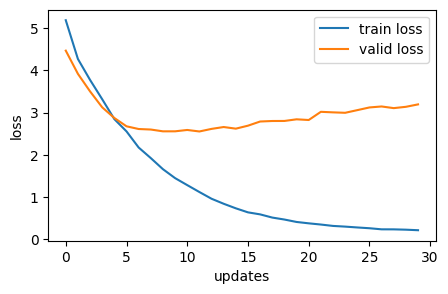

In [53]:
plot_loss(gen_train_loss,gen_val_loss)

Multipicative attention model

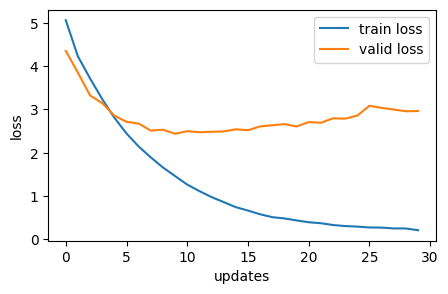

In [54]:
plot_loss(mul_train_loss,mul_val_loss)

Additive attention model

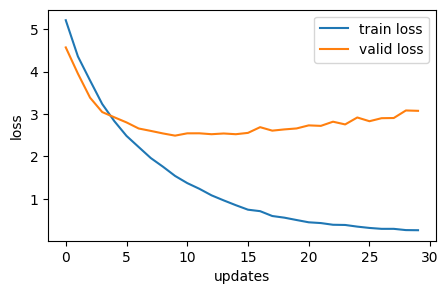

In [55]:
plot_loss(add_train_loss,add_val_loss)

## 7. Testing and inference

### Testing on test set

In [57]:
model = create_model(input_dim,output_dim,SRC_PAD_IDX,TRG_PAD_IDX,'gen')
model.load_state_dict(torch.load('./app/model/gen.pt'))
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 2.787 | Test PPL:  16.238 |


### Inference

In [119]:
sample

('The sea over there is very pretty', 'အဲဒီကပင်လယ်က အရမ်း လှတယ်။')

In [59]:
sample[0]

'The sea over there is very pretty'

In [60]:
sample[1]

'အဲဒီကပင်လယ်က အရမ်း လှတယ်။'

Since batch size is 1, we just take off that dimension

We shall remove the first token since it's zeroes anyway

Then we just take the top token with highest probabilities

Get the mapping of the target language

In [120]:
def infer(src, text_transform,vocab_transform,model,max_len=100):
    src_text = text_transform[SRC_LANGUAGE](src).to(device).unsqueeze(0) 
    # trg_text = text_transform[TRG_LANGUAGE](src).to(device)

    text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)

    model.eval()

    trg_idx = [SOS_IDX]


    for i in range(max_len):
        with torch.no_grad():
            output, attentions = model(src_text, torch.LongTensor(trg_idx).unsqueeze(0).to(device)) #turn off teacher forcing

        pred_token = output.argmax(2)[:, -1].item()
        trg_idx.append(pred_token)
        
        if pred_token == EOS_IDX:
            break
    
    # print(trg_indexes)
    trg_tokens = [vocab_transform[TRG_LANGUAGE].get_itos()[i] for i in trg_idx]
    return trg_tokens[1:], attentions  # E

In [121]:
out,att = infer(sample[0], text_transform,vocab_transform,gen_model,100)
out

['ဟို', 'က', 'အရမ်း', 'လှ', 'တယ်', '။', '<eos>']

## 8. Attention Map and BELU score

Let's display the attentions to understand how the source text links with the generated text

Since there are 8 heads, we can look at just 1 head for sake of simplicity.

In [123]:
def prepare_att_map(src,trg,model,token_transform,vocab_transform):
    src_text = text_transform[SRC_LANGUAGE](src).to(device).reshape(1, -1)
    trg_text = text_transform[TRG_LANGUAGE](trg).to(device).reshape(1, -1)
    model.eval()
    with torch.no_grad():
        output, attentions = model(src_text, trg_text)
    output = output.squeeze(0)
    output = output[1:]
    attention = attentions[0, 0, :, :]

    output_max = output.argmax(1) #returns max indices
    src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](src) + ['<eos>']
    trg_tokens = ['<sos>'] + [vocab_transform[TRG_LANGUAGE].get_itos()[token.item()] for token in output_max]

    return src_tokens,trg_tokens,attention

In [183]:
import matplotlib.font_manager as fm
import matplotlib

# List all system fonts
available_fonts = [f.name for f in fm.fontManager.ttflist]
print(available_fonts)

# Check if Myanmar-compatible fonts are available
myanmar_fonts = [f for f in available_fonts if "Myanmar" in f or "Noto" in f]
print("Myanmar-compatible fonts:", myanmar_fonts)


['STIXSizeOneSym', 'DejaVu Serif', 'STIXGeneral', 'DejaVu Sans Mono', 'STIXSizeThreeSym', 'cmtt10', 'STIXSizeOneSym', 'cmex10', 'STIXNonUnicode', 'STIXSizeTwoSym', 'STIXSizeThreeSym', 'STIXNonUnicode', 'DejaVu Sans Mono', 'STIXGeneral', 'DejaVu Sans Mono', 'STIXSizeFiveSym', 'DejaVu Serif', 'DejaVu Serif Display', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Sans', 'cmmi10', 'cmsy10', 'STIXGeneral', 'DejaVu Sans Display', 'STIXSizeFourSym', 'DejaVu Sans', 'cmb10', 'STIXSizeTwoSym', 'cmr10', 'DejaVu Sans', 'DejaVu Sans Mono', 'DejaVu Sans', 'STIXGeneral', 'STIXSizeFourSym', 'STIXNonUnicode', 'cmss10', 'STIXNonUnicode', 'Nimbus Sans Narrow', 'Latin Modern Mono Light Cond', 'Loma', 'TeX Gyre Bonum Math', 'TeX Gyre Pagella', 'Latin Modern Roman', 'TeX Gyre Schola', 'FreeMono', 'TeX Gyre Bonum', 'Latin Modern Mono Light', 'TeX Gyre Heros Cn', 'Latin Modern Mono Prop', 'FreeSans', 'TeX Gyre Adventor', 'Ubuntu', 'TeX Gyre Pagella Math', 'TeX Gyre Bonum', 'Liberation Serif', 'Nimbus Sans', 'Z003', 

In [185]:
matplotlib.font_manager.get_font_names()

['Latin Modern Roman Slanted',
 'Lato',
 'DejaVu Sans',
 'TeX Gyre Pagella Math',
 'cmtt10',
 'STIXNonUnicode',
 'Noto Sans Mono',
 'Nimbus Mono PS',
 'Z003',
 'TeX Gyre Adventor',
 'Nimbus Sans',
 'TeX Gyre Heros Cn',
 'Latin Modern Mono',
 'Latin Modern Sans',
 'Latin Modern Sans Quotation',
 'TeX Gyre DejaVu Math',
 'Standard Symbols PS',
 'D050000L',
 'TeX Gyre Schola',
 'Ubuntu Condensed',
 'IPAPGothic',
 'STIXGeneral',
 'Latin Modern Roman',
 'TeX Gyre Bonum',
 'Unifont CSUR',
 'Latin Modern Math',
 'Liberation Sans Narrow',
 'Latin Modern Mono Prop',
 'TeX Gyre Termes Math',
 'Latin Modern Mono Light Cond',
 'STIXSizeFourSym',
 'TeX Gyre Bonum Math',
 'Latin Modern Mono Slanted',
 'DejaVu Serif',
 'Ubuntu Mono',
 'P052',
 'DejaVu Serif Display',
 'Latin Modern Mono Prop Light',
 'URW Bookman',
 'Latin Modern Sans Demi Cond',
 'Latin Modern Roman Unslanted',
 'Latin Modern Mono Light',
 'TeX Gyre Cursor',
 'STIXSizeThreeSym',
 'TeX Gyre Termes',
 'DejaVu Sans Display',
 'Latin Mo

In [195]:
import matplotlib.ticker as ticker
# plt.rcParams['font.family'] = 'Noto Mono'

def display_attention(sentence, translation, attention,img_path):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=10)
    
    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence 
    # print(y_ticks)
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks,name='Unifont')

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    fig.savefig(img_path)
    
    plt.show()
    plt.close()

BELU_score : 1.2183324802375697e-231


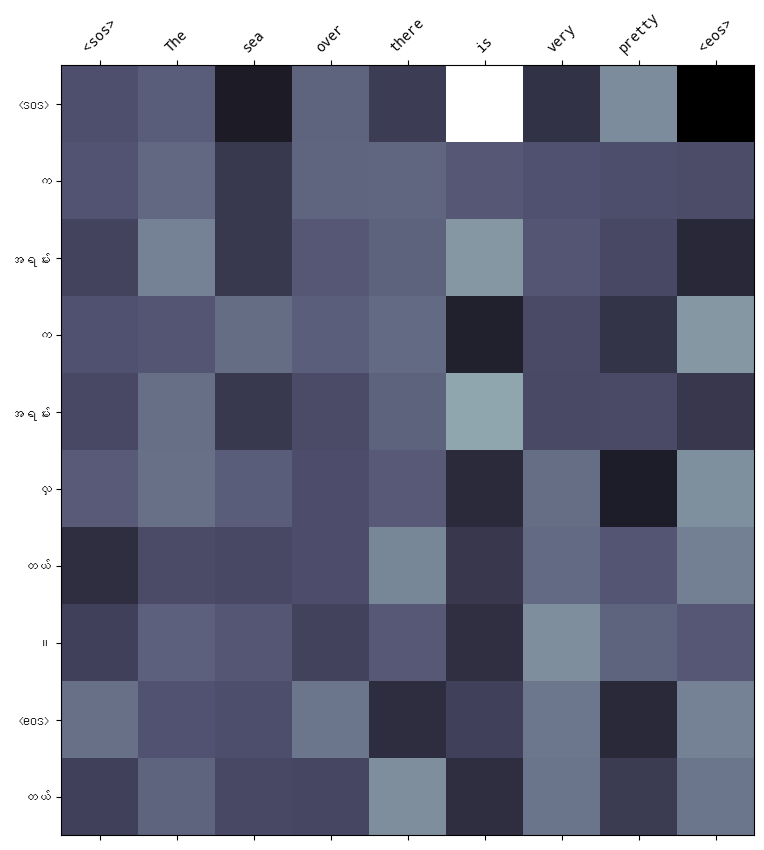

In [196]:
gen_model = create_model(input_dim,output_dim,SRC_PAD_IDX,TRG_PAD_IDX,'gen')
gen_model.load_state_dict(torch.load('./app/model/gen.pt',map_location=torch.device('cpu')))
src_tokens,trg_tokens,attention  = prepare_att_map(sample[0],sample[1],gen_model,token_transform,vocab_transform)
print(f"BELU_score : {sentence_bleu([src_tokens], trg_tokens)}")
display_attention(src_tokens, trg_tokens, attention,"./images/gen_map.png")

BELU_score : 1.2183324802375697e-231


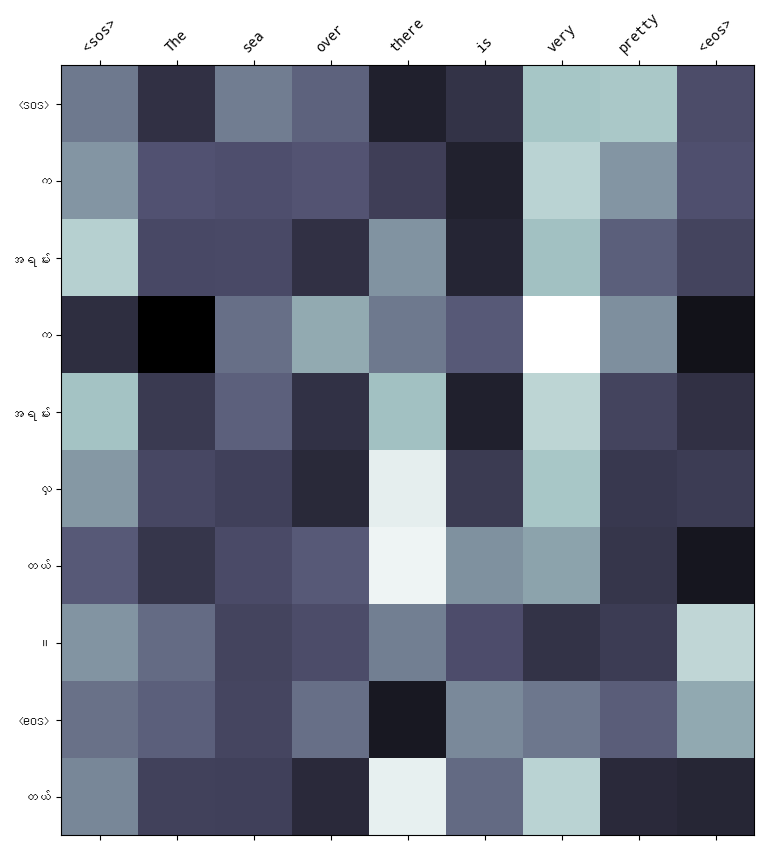

In [197]:
mul_model = create_model(input_dim,output_dim,SRC_PAD_IDX,TRG_PAD_IDX,'mul')
mul_model.load_state_dict(torch.load('./app/model/mul.pt',map_location=torch.device('cpu')))
src_tokens,trg_tokens,attention  = prepare_att_map(sample[0],sample[1],mul_model,token_transform,vocab_transform)
print(f"BELU_score : {sentence_bleu([src_tokens], trg_tokens)}")
display_attention(src_tokens, trg_tokens, attention,'./images/mul_map.png')

BELU_score : 1.2183324802375697e-231


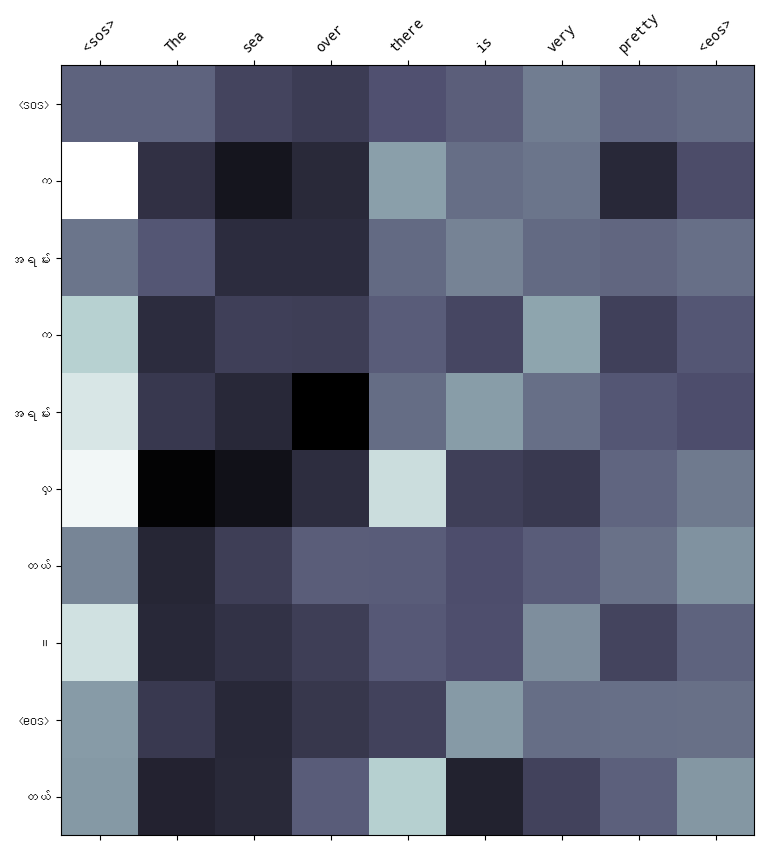

In [198]:
add_model = create_model(input_dim,output_dim,SRC_PAD_IDX,TRG_PAD_IDX,'add')
add_model.load_state_dict(torch.load('./app/model/add.pt',map_location=torch.device('cpu')))

src_tokens,trg_tokens,attention  = prepare_att_map(sample[0],sample[1],add_model,token_transform,vocab_transform)
print(f"BELU_score : {sentence_bleu([src_tokens], trg_tokens)}")
display_attention(src_tokens, trg_tokens, attention,'./images/add_map.png')

## 9. Analysis


In terms of training time, general attention got the best performance while multiplicative attention is slightly better in validation loss. However, the margins are relatively small. So, genreally, the attention mechanisms do not make a significant impact on perforamce and computaional complexity. This might be differnt for a larger corupus. Since the trained corpus is just around 1k sentences, the model training is just done under 10 epochs. It can be seen that the validation loss is not improving anymore beyond 10 epochs